# ARCH/GARCH Volatility Forecasting

### Loading Libraries

In [6]:
# Numerical Computing
import numpy as np
from numpy.linalg import LinAlgError

# Data Manipulation
import pandas as pd
import pandas_datareader.data as web

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# StatsModel
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.tsa.arima.model import ARIMA

# Arch
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

# Scipy
from scipy.stats import probplot, moment

# Warnings
import warnings

# Notebook Optimizer
from tqdm import tqdm

# Itertools
from itertools import product

# Scikit-Learn
from sklearn.metrics import mean_squared_error

In [7]:
%matplotlib inline

In [8]:
sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

#### Correlogram Plotting Function

In [9]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Download `NASDAQ Index` Data

In [10]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2020').squeeze()

# Rescaling Optimization
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) 

### Explore Returns & Volatility

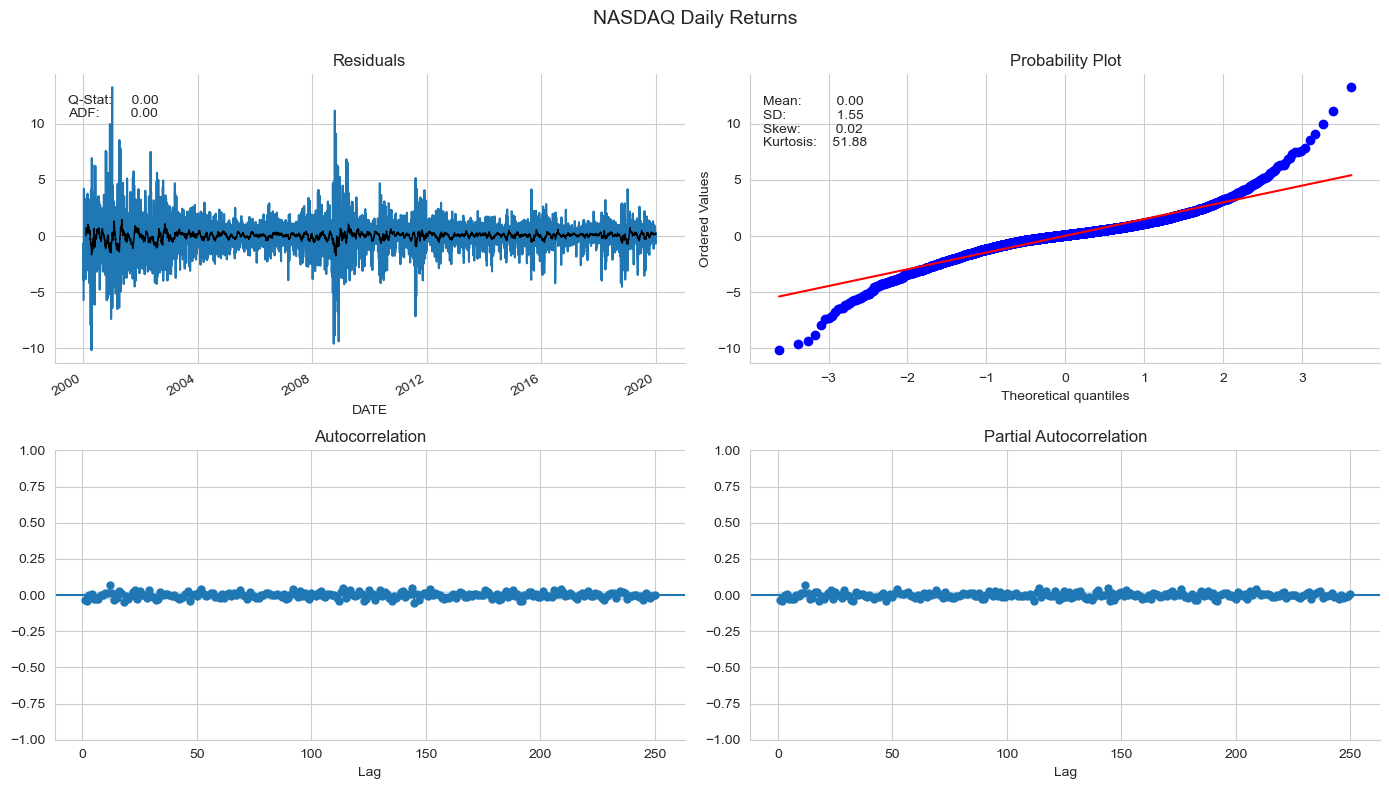

In [13]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

plt.show()

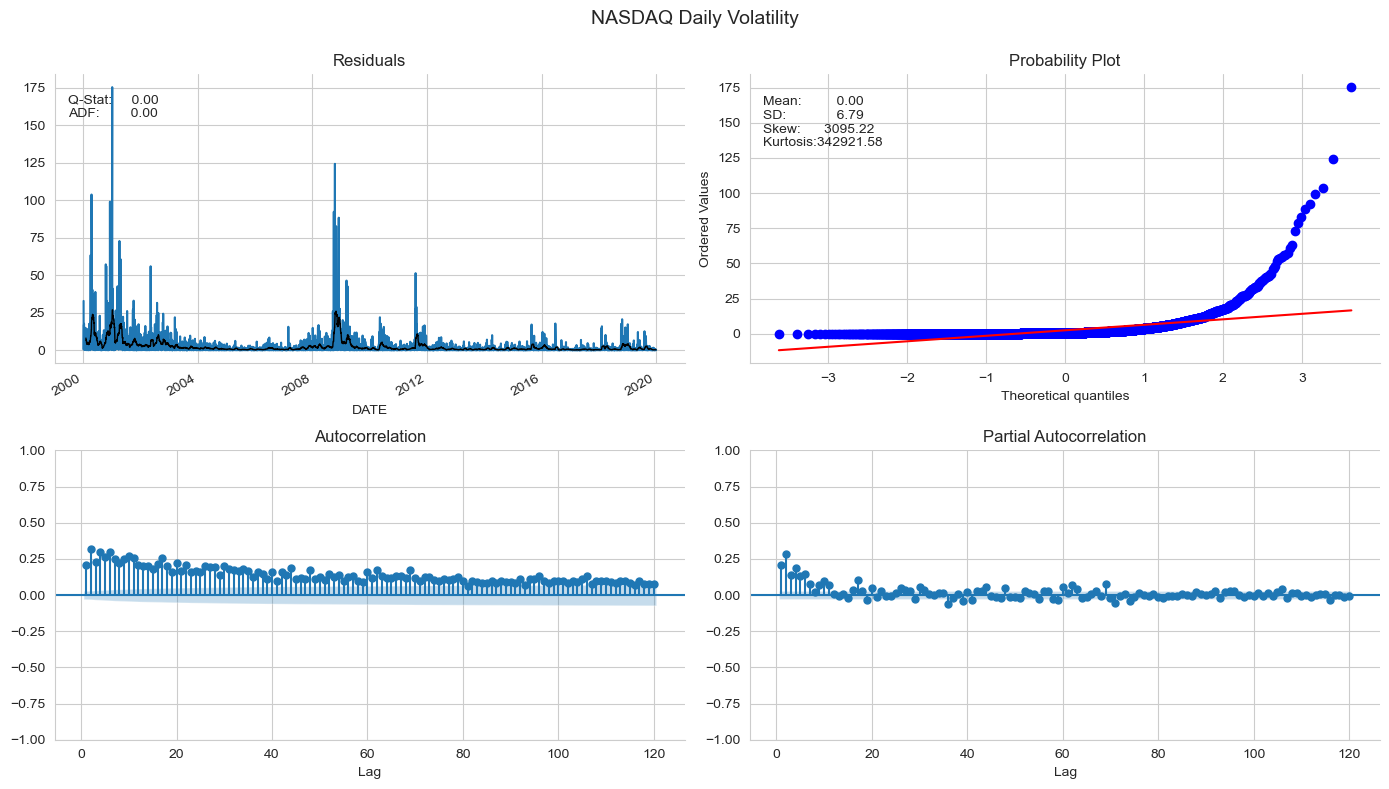

In [14]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

plt.show()

### Model Selection: Rolling out-of-sample Forecasts

In [15]:
trainsize = 10 * 252  
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                           upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}

for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [16]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

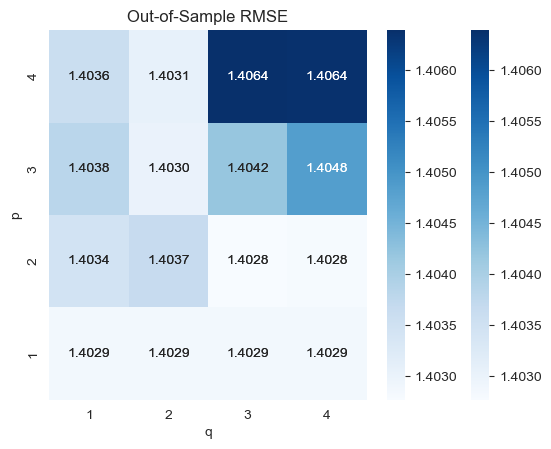

In [18]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');
plt.show()

### Estimate GARCH(2, 2) Model

In [19]:
best_p, best_q = 2, 2,

In [20]:
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05),
                                      upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)

print(best_model.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 7254.92748441108
Iteration:     10,   Func. Count:     86,   Neg. LLF: 7244.082227227334
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7244.081394188299
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7244.08
Distribution:                  Normal   AIC:                           14500.2
Method:            Maximum Likelihood   BIC:                           14539.1
                                        No. Observations:                 4851
Date:                Sat, Apr 12 2025   Df Residuals:                     4850
Time:          

### Checking Residuals

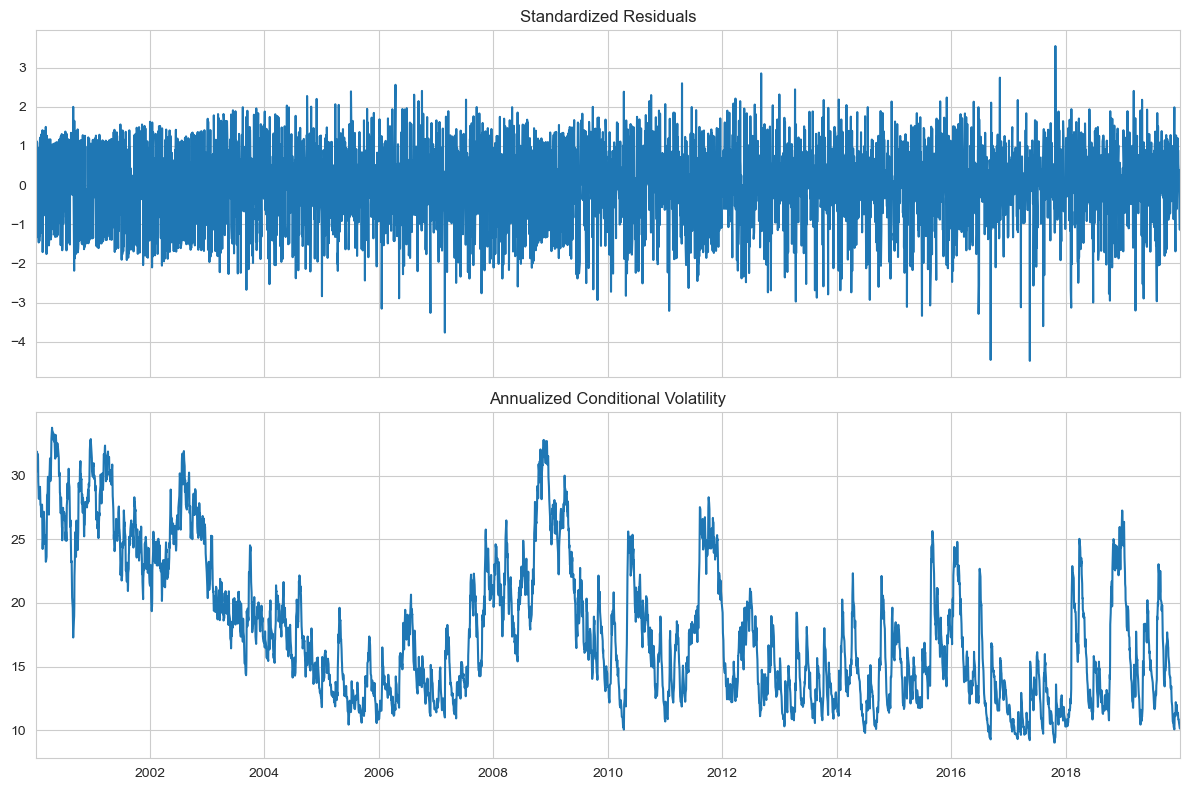

In [25]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

plt.show()

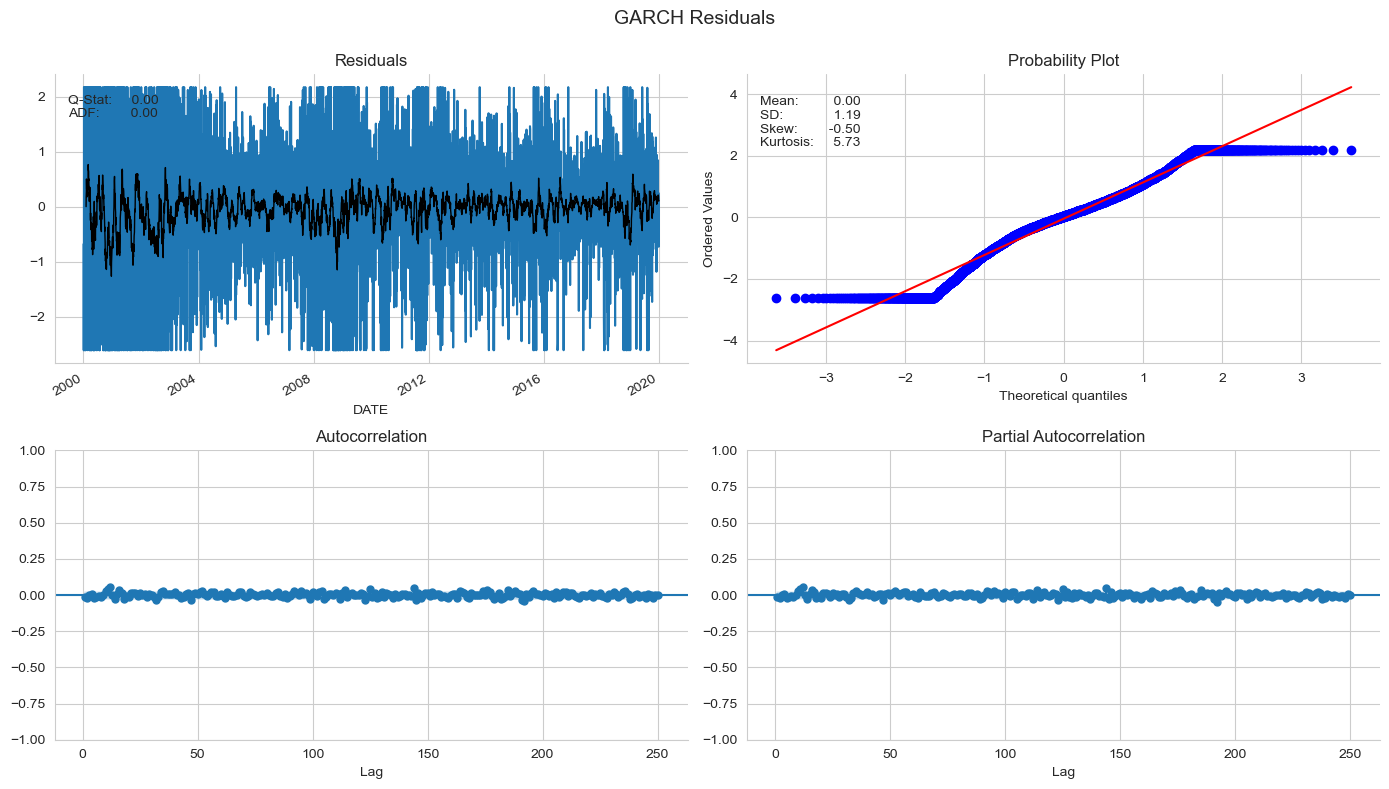

In [28]:
plot_correlogram(best_model.resid.dropna(),
                 lags=250,
                 title='GARCH Residuals')

plt.show()